In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
# Just choose the first one
atlas_img = nib.load('/home/ariel/data/volume/Acoustic_Radiation_L.nii.gz')

In [5]:
atlas_affine = atlas_img.affine
atlas_shape = atlas_img.shape

In [6]:
atlas_shape

(157, 189, 136)

In [7]:
group_dirs = glob('/home/ariel/data/tracks/*')

In [8]:
group_dirs

['/home/ariel/data/tracks/cerebellum',
 '/home/ariel/data/tracks/brainstem',
 '/home/ariel/data/tracks/association',
 '/home/ariel/data/tracks/projection',
 '/home/ariel/data/tracks/commisural',
 '/home/ariel/data/tracks/cranial nerve']

In [9]:
track_files = [glob(op.join(d, '*.trk.gz')) for d in group_dirs]

In [69]:
def read_sl(fname, affine):
    trk = load_trk(fname)
    sl = trk.streamlines
    sl = [dts.apply_affine(np.linalg.inv(affine), s) for s in sl]
    return sl

In [34]:
def reduce_sl(sl):
    """ 
    Reduces a 3D streamline to a binarized 100 x 100 image
    """
    vol = np.zeros((300, 300, 300), dtype=bool)
    sl = np.round(sl).astype(int).T
    vol[sl[0], sl[1], sl[2]] = 1
    # emphasize it a bit:
    vol = binary_dilation(vol, iterations=5)
    vol = resize(vol, (100, 100, 100))
    projected = np.concatenate([np.max(vol, dim) for dim in range(len(vol.shape))])
    projected = resize(projected, (100, 100, 1))
    return projected

In [11]:
exclude = [op.join('/home/ariel/data/tracks/', g) for g in ["cerebellum", "brainstem", "cranial nerve"]]

'AC'

In [62]:
max_x = 0
max_y = 0
max_z = 0
n_streamlines = []
group_names = []
for group_dir, group in zip(group_dirs, track_files):
    if group_dir not in exclude:
        for fname in group:
            group_names.append(fname.split('.')[-3].split('/')[-1])
            streamlines = read_sl(fname) 
            n_streamlines.append(len(streamlines))
            for sl in streamlines:
                if len(sl) > 1:
                    maxes = np.max(sl, 1)
                    max_x = np.max([maxes[0], max_x])
                    max_y = np.max([maxes[1], max_y])
                    max_z = np.max([maxes[2], max_z])
                

In [13]:
max_x, max_y, max_z

(246.71162414550781, 243.90304565429688, 242.99563598632812)

In [14]:
np.max(n_streamlines), np.min(n_streamlines), len(n_streamlines)

(45747, 72, 45)

In [15]:
take_n_bundles = len(n_streamlines)

In [16]:
take_n_sl = np.min(n_streamlines)

In [17]:
take_n_bundles = 45
take_n_sl = 70

In [18]:
data_train = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.6)),  100, 100, 1), dtype='float32')
data_valid = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.2)),  100, 100, 1), dtype='float32')
data_test = np.zeros((np.int(np.round(take_n_bundles * take_n_sl * 0.2)),  100, 100, 1), dtype='float32')

labels_train = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.6)))
labels_valid = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.2)))
labels_test = np.zeros(np.int(np.round(take_n_bundles * take_n_sl * 0.2)))

ii_train = 0
ii_valid = 0
ii_test = 0

tract_id = 0
for group_dir, group in zip(group_dirs, track_files):
    if group_dir not in exclude:
        for fname in group:
            tract_id += 1
            if tract_id > take_n_bundles: 
                break
            streamlines = read_sl(fname, atlas_affine) 
            choose_sl = streamlines[:take_n_sl]
            # Shuffle them in case they are ordered somehow:
            np.random.shuffle(choose_sl)
            for sl_idx, sl in enumerate(choose_sl):
                assert np.all(sl > 0), "Negatory"
                projected = reduce_sl(sl)
                if sl_idx < (np.round(take_n_sl * 0.2)):
                    data_test[ii_test] = projected
                    labels_test[ii_test] = tract_id
                    ii_test += 1
                elif sl_idx < (np.round(take_n_sl * 0.4)):
                    data_valid[ii_valid] = projected
                    labels_valid[ii_valid] = tract_id
                    ii_valid += 1
                else:
                    data_train[ii_train] = projected
                    labels_train[ii_train] = tract_id
                    ii_train += 1

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [19]:
img_rows = 100
img_cols = 100
batch_size = 5
epochs = 12
num_classes = 45
input_shape = (img_rows, img_cols, 1)

In [20]:
labels_train = keras.utils.to_categorical(labels_train-1, num_classes)
labels_valid = keras.utils.to_categorical(labels_valid-1, num_classes)
labels_test  = keras.utils.to_categorical(labels_test-1, num_classes)

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [23]:
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_valid, labels_valid))

Train on 1890 samples, validate on 630 samples
Epoch 1/12
1890/1890 [==============================] - 33s - loss: 1.1058 - acc: 0.7085 - val_loss: 0.0449 - val_acc: 0.9841
Epoch 2/12
1890/1890 [==============================] - 32s - loss: 0.1477 - acc: 0.9582 - val_loss: 0.0106 - val_acc: 0.9968
Epoch 3/12
1890/1890 [==============================] - 32s - loss: 0.0980 - acc: 0.9704 - val_loss: 0.0120 - val_acc: 0.9968
Epoch 4/12
1890/1890 [==============================] - 32s - loss: 0.0620 - acc: 0.9778 - val_loss: 0.0057 - val_acc: 0.9968
Epoch 5/12
1890/1890 [==============================] - 32s - loss: 0.0375 - acc: 0.9894 - val_loss: 0.0094 - val_acc: 0.9968
Epoch 6/12
1890/1890 [==============================] - 32s - loss: 0.0437 - acc: 0.9857 - val_loss: 0.0044 - val_acc: 0.9984
Epoch 7/12
1890/1890 [==============================] - 32s - loss: 0.0277 - acc: 0.9910 - val_loss: 0.0075 - val_acc: 0.9984
Epoch 8/12
1890/1890 [==============================] - 32s - loss: 0.0

In [24]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [25]:
print(score)

[0.024994058040882765, 0.99682539682539684]


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

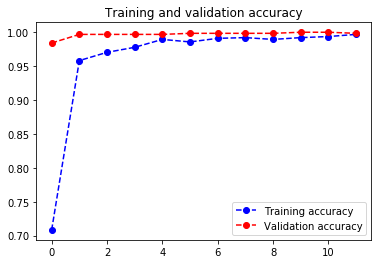

In [27]:
accuracy = training.history['acc']
val_accuracy = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo--', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()